#                                             Importing Python Libraries


In [240]:
import numpy as np
import scipy
import slycot
import control as ctrl
import matplotlib.pyplot as plt

# Define Your System (Linear/Nonlinear)
## (USER SECTION)

This simulator takes system states (A), and system input (B), and the desired output (Z) as the input
The user need to tune the tuning parameter Q and R to get the desired output.

In [241]:
# Dfine your initial states and input
## Define the initial states of your system and the initial input of the system
X = np.array([[15],[-13],[-12]])
u = np.array([0])

# Define start time
t = 0
# Define Final time
tf = 10


# Define your system here
## As an example we have taken a simple system for simplicity. This system has 3 states and its a linear system. Things 
## will work same as nonlinear systems. You just need to put the equation of your system. 
## See the published paper for more Clarifications
A = np.array([[-1.01887, 0.90506, -0.00215],[0.82225, -1.07741, -0.17555],[0, 0,-1]])

# Define input of your system
## The states we have taken as an example has only one input. So, the matrix size becomes 3x1, since the state is 3.
B = np.array([[0],[0],[0.25]])

# Define your tuning parameter Q
## Tune your parameter Q here.
Q = np.array([[250,0,0],[0,100,0],[0,0,100]])

# Define tuning parameter R
## Tune your parameter R here.
R = np.array([0.1])

# Define output matrix C. 
## We want all our states as our output
C = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Define Ptf
## You can tune your ptf here or keep it like this.
Ptf = np.array([[1,1,0.5],[1,1,1],[1,0.5,1]])

# Define your desired state. You may need to do little modification if the desired states depends on other states. 
# Please see the attached paper for explanation.
## This is your reference trajectory. We want the example state to follow zero reference.
Z = np.array([[0],[0],[0]])

# Define Ztf
## You can change it as your requirement or keep it like this.
Ztf = np.array([[0],[0],[0]])

# Calculating Size of States and Inputs

In [166]:
def count_ux(u,X,Z):
    
    state_variable = []
    state_desired = []
    control_param_box = []
    control_param_box2 = {}
    control_u = "c"
    
    state_dict = {}  
    desired_dict = {}
    state_x = 'x'
    state_z = 'z'
        
    len_u = len(u)
    for i in range(len_u):
        control_param_box2[control_u+str(i+1)] = []
        control_param_box.append(control_u+str(i+1))   
          
    len_X = len(X)
    for j in range(len_X):
        state_dict[state_x+str(j+1)] = []
        state_variable.append(state_x+str(j+1)) 
        
    len_Z = len(Z)
    for j in range(len_Z):
        desired_dict[state_z+str(j+1)] = []
        state_desired.append(state_z+str(j+1)) 
        
    return control_param_box, control_param_box2, state_dict, state_variable, state_desired, desired_dict

In [167]:
control_param_box, control_param_box2, state_dict,state_variable, state_desired, desired_dict = count_ux(u,X,Z)
print("control_param_box", control_param_box)
print("control_param_box2", control_param_box2)
print("state_dict",state_dict)
print("state_variable",state_variable)
print("state_desired",state_desired)
print("desired_dict",desired_dict)

control_param_box ['c1']
control_param_box2 {'c1': []}
state_dict {'x1': [], 'x2': [], 'x3': []}
state_variable ['x1', 'x2', 'x3']
state_desired ['z1', 'z2', 'z3']
desired_dict {'z1': [], 'z2': [], 'z3': []}


# SS-RE and ALE Calculation

This section calculates the Steady-State Riccati Equation (SS-RE), and Algebraic Lyapunov Equation. SS-RE and ALE are required to solve Differential Lyapunov Equation (DLE), which has been solved in the next state of the program.

In [168]:
def regulation(A,B,Q,R,C,Ptf):
    X,L,G = ctrl.lqr(A,B,Q,R)
    g = np.array([-1])
    Pss = np.multiply(X,g)
    Pss = L
    Ktf = np.linalg.inv(Ptf - Pss)
    if len(R)>1:
        r = np.linalg.inv(R)
        E1 = np.matmul(B,r)
        E = np.matmul(E1,np.transpose(B))
    else:
        r = np.reciprocal(R)
        E1 = np.multiply(B,r)
        E = np.multiply(E1,np.transpose(B))
    
    Acl = A - np.matmul(E,Pss)
    D = scipy.linalg.solve_lyapunov(Acl, E)
    return Pss, Ktf, E, Acl, D

In [169]:
Pss, Ktf, E, Acl, D = regulation(A,B,Q,R,C,Ptf)
print("Pss",Pss)
print("Ktf",Ktf)
print("E",E)
print("Acl",Acl)
print("D",D)

Pss [[271.18201521 190.57038965  -4.15587605]
 [190.57038965 201.04541324  -4.33379212]
 [ -4.15587605  -4.33379212  11.24613341]]
Ktf [[-0.0110423   0.01047461  0.00043507]
 [ 0.01044736 -0.01497279 -0.00304702]
 [-0.00062779 -0.00179283 -0.09881635]]
E [[0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.625]]
Acl [[-1.01887000e+00  9.05060000e-01 -2.15000000e-03]
 [ 8.22250000e-01 -1.07741000e+00 -1.75550000e-01]
 [ 2.59742253e+00  2.70862008e+00 -8.02883338e+00]]
D [[-1.25326278e-04 -1.41097198e-04 -4.76505110e-06]
 [-1.41097198e-04 -2.12345193e-04  6.42356383e-04]
 [-4.76505110e-06  6.42356383e-04 -3.87070528e-02]]


# Solve Differential Lyapunov Equation (DLE)

Please follow the attached published paper to know details about DLE

In [170]:
def solve_dle(Acl, Ktf, t, tf, D):
    kk1 = np.exp(np.multiply(Acl,(t-tf)))
    kk2 = np.matmul(kk1,(Ktf-D))
    kk3 = np.exp(np.multiply(np.transpose(Acl),(t-tf)))
    KK = np.matmul(kk2,kk3) + D
    return KK

In [171]:
KK = solve_dle(Acl, Ktf, t, tf, D)
print("KK",KK)

KK [[-7.72493976e+06  1.34888677e+07  8.60358460e+35]
 [ 1.34540156e+07 -3.36810508e+07 -1.30533367e+37]
 [-1.22966760e+36 -8.62464820e+36 -3.28474978e+68]]


# Solve Differential Riccati Equation (DRE)

So, to solve DRE, we needed to solve DLE. And to solve DLE, we needed to solve SS-RE, and ALE. In the final equation, we just need to put the value of SS-RE, and ALE.

In [172]:
def solve_riccati_coefficient(Pss, KK):
    Pxt = np.linalg.inv(KK) + Pss
    return Pxt

In [173]:
Pxt = solve_riccati_coefficient(Pss, KK)
print("Pxt",Pxt)

Pxt [[271.18201477 190.57038947  -4.15587605]
 [190.57038947 201.04541314  -4.33379212]
 [ -4.15587605  -4.33379212  11.24613341]]


# Solve VAE and VDE

Upto now, we have solved DRE. To find the solution of SDRE, we also need to solve Vector Differential Equation (VDE) simultaneously with DRE at each iteration. More details about the solution procedures of VDE can be found in the attached paper.

In [174]:
def solve_vector_coefficient(A, Pxt, C, Z, Q, Ztf):
    #s = -inv(A - B*(inv(R))*B'*Pe)'*C'*Q*z
    #gss1 = np.matmul(E, Pxt) 
    gss3 = -scipy.linalg.inv(np.transpose(A-np.matmul(E, Pxt)))
    #gss2 = scipy.linalg.inv(np.transpose(A-gss1))
    gss4 = np.matmul(gss3,np.transpose(C))
    gss5 = np.matmul(gss4, Q)
    gss = np.matmul(gss5, Z)
    AA = A - np.matmul(E,Pxt)
    BB = E
    kg1 = np.exp(np.multiply(np.transpose(A-AA),(t-tf)))
    gtf = np.matmul((np.matmul(np.transpose(C),Ptf)),Ztf)
    Kg = np.matmul(kg1, gtf-gss)
    nn = gtf-gss
    return Kg, AA, BB, gss

In [175]:
Kg, AA, BB,gss = solve_vector_coefficient(A, Pxt, C, Z, Q, Ztf)
print("Kg",Kg)
print("AA",AA)
print("BB",BB)
print("gss",gss)

Kg [[0.]
 [0.]
 [0.]]
AA [[-1.01887000e+00  9.05060000e-01 -2.15000000e-03]
 [ 8.22250000e-01 -1.07741000e+00 -1.75550000e-01]
 [ 2.59742253e+00  2.70862008e+00 -8.02883338e+00]]
BB [[0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.625]]
gss [[0.]
 [0.]
 [0.]]


# Solve States

In [176]:
def evaluate_xdot(Kg, gss, AA, X):
    gxt = gss
    xdot = np.matmul(AA,X) + np.matmul(BB,gxt)
    return xdot, gxt

In [177]:
xdot, gxt = evaluate_xdot(Kg, gss, AA, X)
print("xdot",xdot)
print("gxt",gxt)

xdot [[-27.02303   ]
 [ 28.44668   ]
 [100.09527756]]
gxt [[0.]
 [0.]
 [0.]]


# Solve Control Input

In [178]:
def control(R,B,Pxt,X,gxt):
    if len(R)>1:
        r = np.linalg.inv(R)
        b = np.transpose(B)
        zz = np.matmul(Pxt, X)-gxt
        u = -np.matmul((np.matmul(r,b)),zz)
    else:
        r = np.reciprocal(R)
        b = np.transpose(B)
        zz = np.matmul(Pxt, X)-gxt
        u = -np.matmul((np.multiply(r,b)),zz)    
    return u

In [179]:
u = control(R,B,Pxt,X,gxt)
print("u",u)

u [[352.38111022]]


# Main Function

In [180]:
def main(A,B,Q,R,C,Ptf,Z,Ztf,X,control_param_box, control_param_box2, state_dict, state_variable, state_desired, desired_dict):
    import time
    start_time = time.time()    
    time_variable = ["t1"]   
    #############
    t = 0
    tf = 20
    delta = 0.001
    #############    
    time_step = []
    #delta = 0.01
    while t <= tf:        
        m = 0
        k = 0
        l = 0
        Pss, Ktf, E, Acl, D = regulation(A,B,Q,R,C,Ptf)
        KK = solve_dle(Acl, Ktf, t, tf, D)
        Pxt = solve_riccati_coefficient(Pss, KK)
        Kg, AA, BB, gss = solve_vector_coefficient(A, Pxt, C, Z, Q, Ztf)
        xdot, gxt = evaluate_xdot(Kg, gss, AA, X)
        u = control(R,B,Pxt,X,gxt)
        X = X + np.multiply(delta, xdot)
        
        time_step.append(t)
        for item in control_param_box:
            control_param_box2[item].append(u[m])
            m = m+1        
        for item2 in state_variable:
            state_dict[item2].append(X[k])
            k = k + 1 
        for item3 in state_desired:
            desired_dict[item3].append(Z[l])
            l = l + 1 
        t = t + delta            
    #print(time_step)   
    time_dict = {'t1':time_step}
    print("--- %s seconds ---" % (time.time() - start_time))
    return state_dict, control_param_box2, state_variable,control_param_box, time_dict, state_desired, desired_dict
    
    

In [181]:
state_dict, control_param_box2, state_variable,control_param_box, time_dict, state_desired, desired_dict = main(A,B,Q,R,C,Ptf,Z,Ztf,X,control_param_box, control_param_box2, state_dict, state_variable, state_desired, desired_dict)
#print(state_dict)
print("\n")
#print(control_param_box2)

--- 6.763983488082886 seconds ---




C:\Users\User\AppData\Local\conda\conda\envs\UserEnv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\User\AppData\Local\conda\conda\envs\UserEnv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in matmul
  del sys.path[0]


# Plot States

In [222]:
def state_plot_function(state_dict, control_param_box2, state_variable,control_param_box, time_dict, state_desired, desired_dict):
    ccc = time_dict['t1']
    len_sv = len(state_variable)
    len_sd = len(state_desired)
    for i in range(len_sv):
        plt.figure(i+1, figsize = (13,9))
        plt.plot(ccc, state_dict[state_variable[i]], 'b', ccc, desired_dict[state_desired[i]], 'r--', linewidth=3)    
        plt.xlabel('Time [sec]', fontsize = 16)
        plt.ylabel('State '+str(i+1), fontsize = 16)
        plt.title('Time vs State '+str(i+1), fontsize = 20)
        plt.legend(['Actual State', 'Desired State'], fontsize = 12)

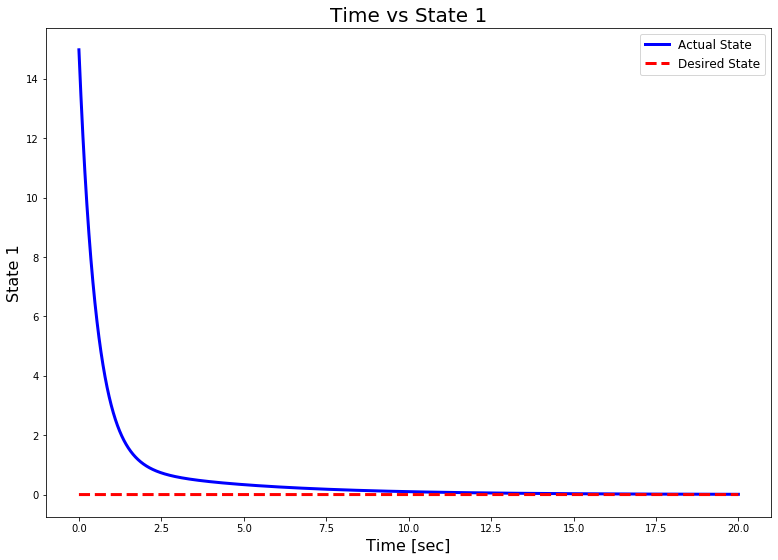

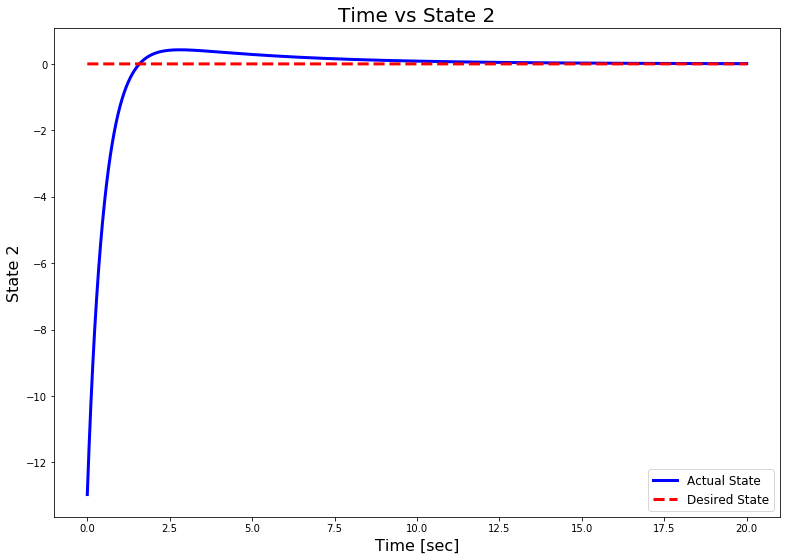

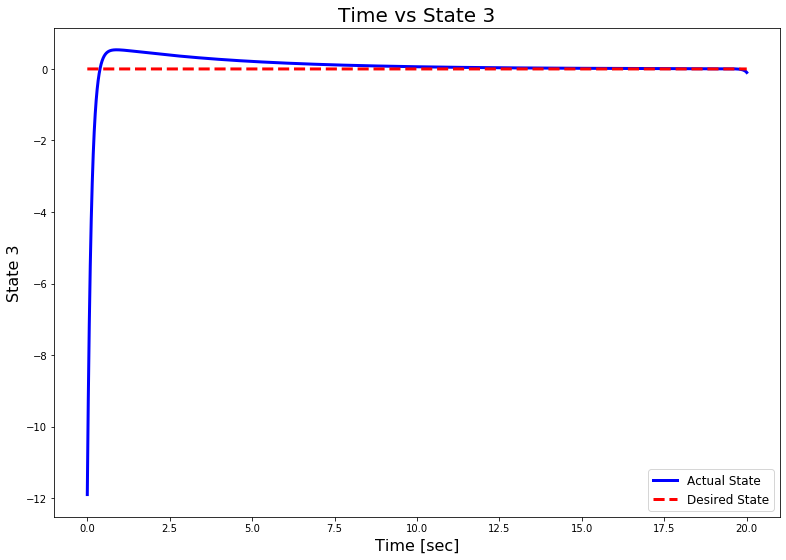

In [223]:
state_plot_function(state_dict, control_param_box2, state_variable,control_param_box, time_dict, state_desired, desired_dict)

# Plot Control Inputs

In [238]:
def control_plot_function(state_dict, control_param_box2, state_variable,control_param_box, time_dict):
    ccc = time_dict['t1']
    len_cp = len(control_param_box)
    for j in range(len_cp):        
        
        plt.figure(j+1, figsize = (13,9))
        plt.plot(ccc, control_param_box2[control_param_box[j]], linewidth = 3)
        plt.xlabel('Time [sec]', fontsize = 16)
        plt.ylabel('Control Signal ', fontsize = 16)
        plt.title('Time vs Control Signal '+ str(j+1), fontsize = 20)
        plt.legend(['Control Signal '+str(j+1)], fontsize = 12)

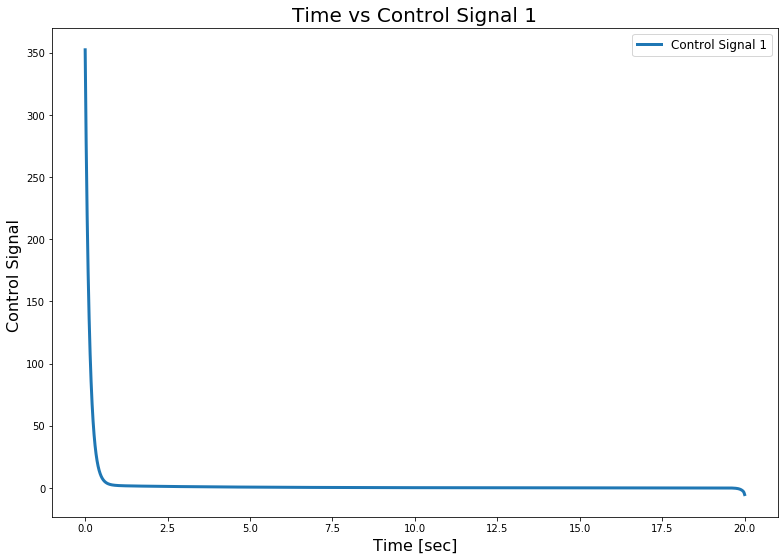

In [239]:
control_plot_function(state_dict, control_param_box2, state_variable,control_param_box, time_dict)